# Modelling Uncertainty with PyMC3

TODO

## A (very) Quick Introduction to Bayesian Data Analysis

Like statistical data analysis more broadly, the main aim of Bayesian Data Analysis (BDA) is to infer unknown parameters for models of observed data, in order to test hypotheses about the physical processes that lead to the observations. Bayesian data analysis deviates from traditional statistics - on a practical level - when it comes to the explicit assimilation of prior knowledge regarding the uncertainty of the model parameters, into the statistical inference process and overall analysis workflow. To this end, BDA focuses on the posterior distribution,

$$
p(\Theta | X) = \frac{p(X | \Theta) \cdot p(\Theta)}{p(X)}
$$

Where,

- $\Theta$ is the vector of unknown model parameters, that we wish to estimate; 
- $X$ is the vector of observed data;
- $p(X | \Theta)$ is the likelihood function that models the probability of observing the data for a fixed choice of parameters; and,
- $p(\Theta)$ is the prior distribution of the model parameters.

For an **excellent** (inspirational) introduction to practical BDA, take a look at [Statistical Rethinking by Richard McElreath](https://xcelab.net/rm/statistical-rethinking/), or for a more theoretical treatment try [Bayesian Data Analysis by Gelman & co.](http://www.stat.columbia.edu/~gelman/book/).

This notebook is concerned with demonstrating and comparing two separate approaches for inferring the posterior distribution, $p(\Theta | X)$, for a linear regression model.

## Imports

In [1]:
import warnings

import arviz as az
import joblib
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from numpy.random import binomial, randn, uniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

## Config

In [2]:
az.style.use("arviz-darkgrid")
sns.set()
warnings.filterwarnings("ignore")

## Create Synthetic Dataset

We will assume that there is a dependent variable (or labelled data) $\tilde{y}$, that is a linear function of independent variables (or feature data), $x$ and $c$. In this instance, $x$ is a positive real number and $c$ denotes membership to one of two categories that occur with equal likelihood. We express this model mathematically, as follows,

$$
\tilde{y} = \alpha_{c} + \beta_{c} \cdot x + \sigma \cdot \tilde{\epsilon}
$$

where $\tilde{\epsilon} \sim N(0, 1)$, $\sigma$ is the standard deviation of the noise in the data and $c \in \{0, 1\}$ denotes the category. We start by defining our *a priori* choices for the model parameters.

,y,x,category
0,7.040238,4.487991,1
1,4.465966,3.042377,0
2,5.254621,4.525718,0
3,5.059998,3.499205,0
4,1.353068,1.325612,1


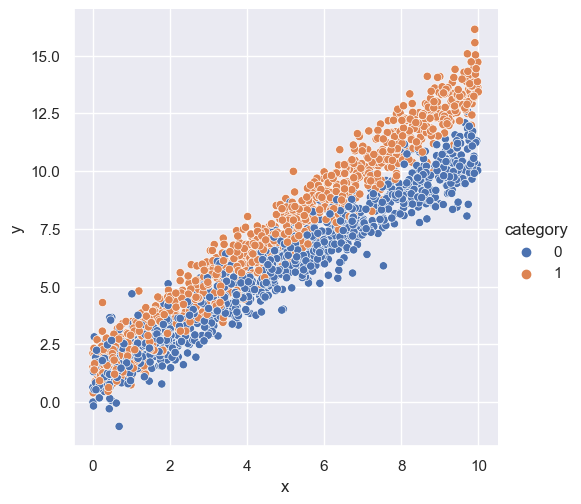

In [3]:
alpha_0 = 1
alpha_1 = 1.25
beta_0 = 1
beta_1 = 1.25
sigma = 0.75

n_samples = 2000

category = binomial(n=1, p=0.5, size=n_samples)
x = uniform(low=0, high=10, size=n_samples)

y = ((1 - category) * alpha_0 + category * alpha_1
     + ((1 - category) * beta_0 + category * beta_1) * x
     + sigma * randn(n_samples))

model_data = pd.DataFrame({"y": y, "x": x, "category": category})

display(model_data.head())
_ = sns.relplot(x="x", y="y", hue="category", data=model_data)

### Split Data into Training and Test Sets

One of the advantages of generating synthetic data is that we can ensure we have enough data to be able to partition it into two sets - one for training models and one for testing models. We use a helper function from the Scikit-Learn package for this task and make use of stratified sampling to ensure that we have a balanced representation of each category in both training and test datasets.

In [4]:
train, test = train_test_split(model_data, test_size=0.2, stratify=model_data.category)

## Define Model

In [23]:
model = pm.Model()

with model:
    y = pm.Data("y", train["y"])
    x = pm.Data("x", train["x"])
    category = pm.Data("category", train["category"])

    alpha_prior = pm.HalfNormal("alpha", sd=2, shape=2)
    beta_prior = pm.Normal("beta", mu=0, sd=2, shape=2)
    sigma_prior = pm.HalfNormal("sigma", sd=2, shape=1)
    mu_likelihood = alpha_prior[category] + beta_prior[category] * x
    obs_likelihood = pm.Normal("obs", mu=mu_likelihood, sd=sigma_prior, observed=y)

## Train Model

In [24]:
with model:
    inference = pm.sample(draws=5000, tune=1000, cores=2, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 49 seconds.


### Diagnostic Plots

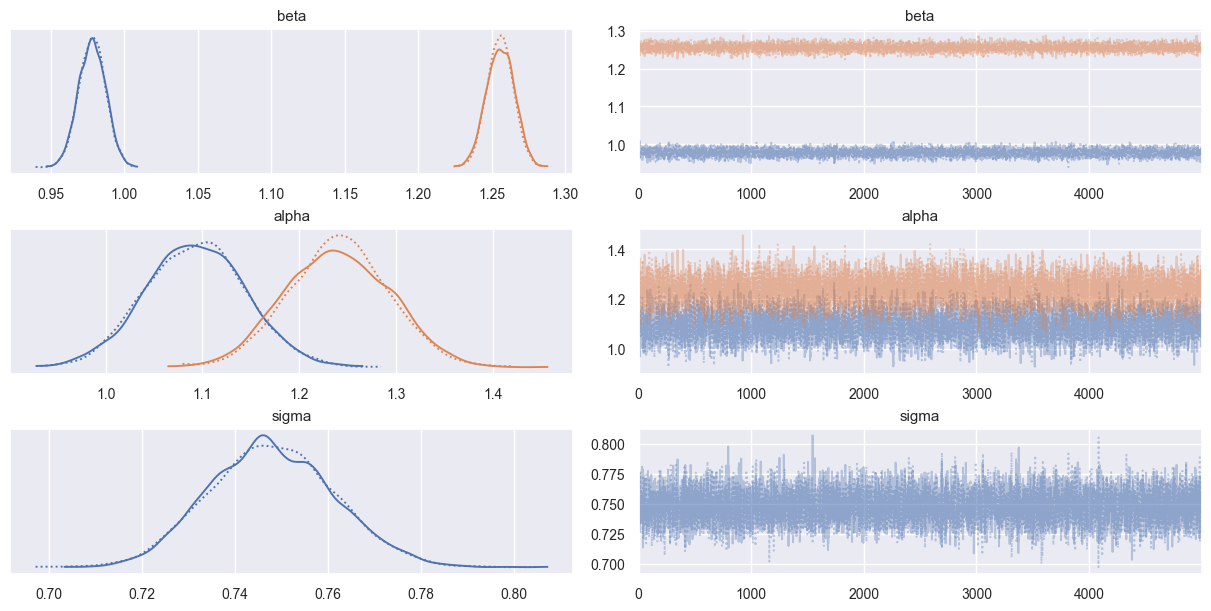

In [25]:
_ = az.plot_trace(inference)

TODO

In [10]:
az.summary(inference, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.98,0.01,0.96,1.00,0.0,0.0,5721.38,5914.99,1.0
beta[1],1.26,0.01,1.24,1.27,0.0,0.0,4946.59,4565.13,1.0
alpha[0],1.09,0.05,1.00,1.19,0.0,0.0,5924.65,6091.99,1.0
alpha[1],1.24,0.05,1.14,1.34,0.0,0.0,5121.79,5470.08,1.0
sigma[0],0.75,0.01,0.72,0.77,0.0,0.0,8434.30,6113.62,1.0


### Posterior Predictive Plot

<AxesSubplot:xlabel='obs'>

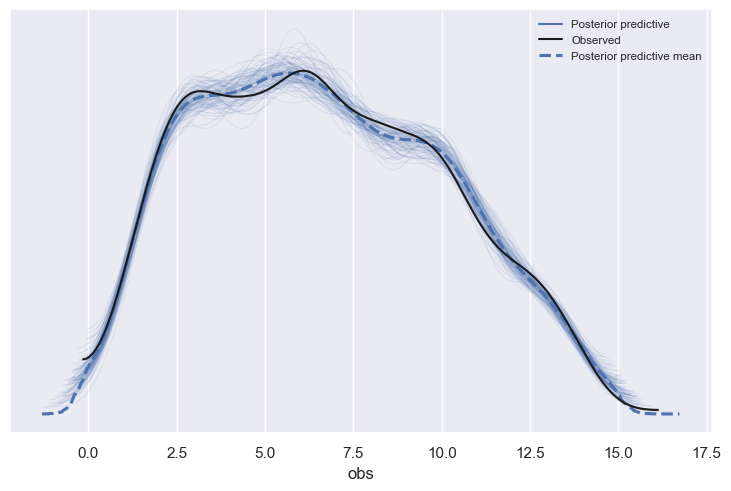

In [37]:
with model:
    posterior_pred_data = az.from_pymc3(
        posterior_predictive=pm.sample_posterior_predictive(
            inference.posterior, samples=100
        )
    )

az.plot_ppc(temp, alpha=0.1)

## Test Model

mean abs. pct. error = 15.71%


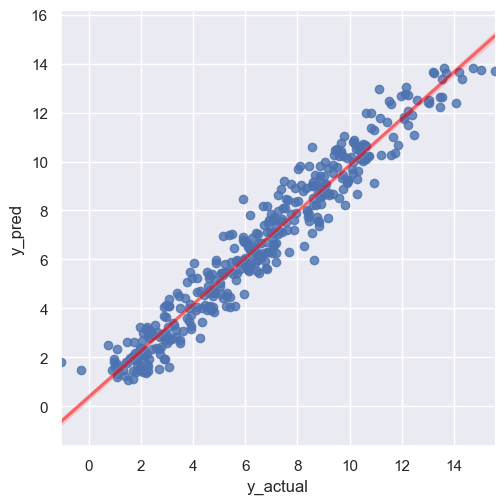

In [15]:
with model:
    pm.set_data({
        "y": test["y"],
        "x": test["x"],
        "category": test["category"]
    })
    posterior_pred = pm.sample_posterior_predictive(
        inference.posterior, samples=100
    )
    predictions = np.mean(posterior_pred["obs"], axis=0)

mape = mean_absolute_percentage_error(test["y"], predictions)
print(f"mean abs. pct. error = {mape:.2%}")
    
prediction_data = pd.DataFrame({"y_pred": predictions, "y_actual": test["y"]})
_ = sns.lmplot(
    y="y_pred",
    x="y_actual",
    data=prediction_data,
    line_kws={"color": "red", "alpha": 0.5}
)

## Persist Model

In [16]:
inference.to_netcdf("model_inference.nc")

'model_inference.nc'

In [17]:
joblib.dump(model, "model_definition.joblib")

['model_definition.joblib']

## Re-Load and Test

In [20]:
inference_test = az.from_netcdf("model_inference.nc")
model_test = joblib.load("model_definition.joblib")

In [21]:
with model_test:
    pm.set_data({
        "y": [0],
        "x": [10],
        "category": [0]
    })
    posterior_pred = pm.sample_posterior_predictive(
        inference_test.posterior, samples=100
    )
    prediction = np.mean(posterior_pred["obs"], axis=0)[0]
    print(f"y_pred = {prediction:.2f}")

y_pred = 10.82
